<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-05-04 18:35:09--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.03s   

2022-05-04 18:35:10 (720 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

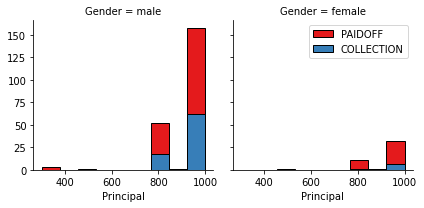

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

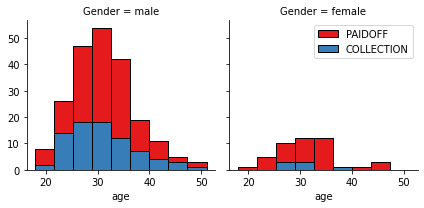

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


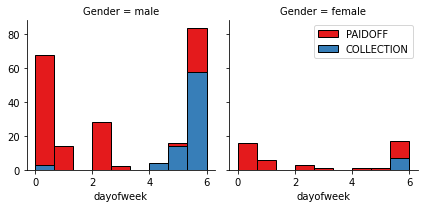

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()
df['education'].replace(to_replace=['Bechalor', 'High School or Below'], value = ['Bachelor or Below', 'Bachelor or Below'], inplace=True)

## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education          loan_status
Bachelor or Below  PAIDOFF        0.743590
                   COLLECTION     0.256410
Master or Above    COLLECTION     0.500000
                   PAIDOFF        0.500000
college            PAIDOFF        0.765101
                   COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,Bachelor or Below
1,1000,30,33,1,Bachelor or Below
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bachelor or Below,college
0,1000,30,45,0,0,1,0
1,1000,30,33,1,0,1,0
2,1000,15,27,0,0,0,1
3,1000,30,28,1,1,0,1
4,1000,30,29,0,1,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bachelor or Below,college
0,1000,30,45,0,0,1,0
1,1000,30,33,1,0,1,0
2,1000,15,27,0,0,0,1
3,1000,30,28,1,1,0,1
4,1000,30,29,0,1,0,1


What are our lables?


In [18]:

df['loan_status_bin'] = df['loan_status'] == 'COLLECTION'
df['loan_status_bin'] = df['loan_status_bin'].astype(int)
y = df['loan_status_bin']





## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
Xscaler= preprocessing.StandardScaler().fit(X)
X = Xscaler.transform(X)
X[:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
         0.87997669, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -1.13639374,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -1.13639374,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -1.13639374,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.



In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# Split the data into training and test cohorts. I'll use a 70/30 split.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 666)

# We'll start by initializing the model with k = 5. We'll refine this choice later on to find the optimal value.

k = 5

KNN = KNeighborsClassifier(n_neighbors = k)

KNN.fit(x_train, y_train)


KNeighborsClassifier()

In [21]:
# Let's now evaluate our model

from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

y_hat = KNN.predict(x_test)
print(classification_report(y_test, y_hat))


# Since our primary concern is to identify those with the highest likelihood of defaulting on their loans, we would like for the precision and recall
# for the 'COLLECTION' class to be higher (as well as the f1-score). We'll now loop through and try to identify the value of k that produces the highest
# predictive performance for defaulters in the test set (measured by the recall score)


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        77
           1       0.43      0.33      0.38        27

    accuracy                           0.71       104
   macro avg       0.61      0.59      0.59       104
weighted avg       0.69      0.71      0.70       104



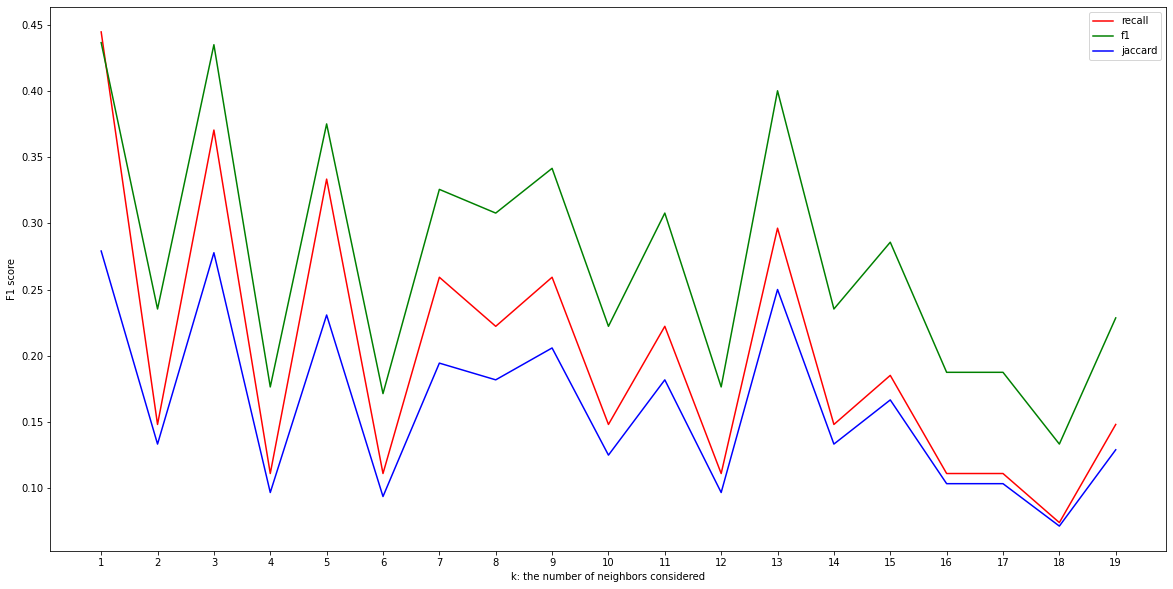

In [22]:
# Let's set up a grid of k values to test

k = np.arange(1,20,1)
recall_scores = []
f1_scores = []
jaccard_scores = []

for i in k:
    KNN = KNeighborsClassifier(n_neighbors = i)
    KNN.fit(x_train, y_train)
    recall_scores.append(recall_score(y_test, KNN.predict(x_test)))
    f1_scores.append(f1_score(y_test, KNN.predict(x_test)))
    jaccard_scores.append(jaccard_score(y_test, KNN.predict(x_test)))

    
# Create a line plot of the recall scores, with scores on the y axis and k on the x axis


import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(k, recall_scores, color = 'r')
plt.plot(k, f1_scores, color = 'g')
plt.plot(k, jaccard_scores, color = 'b')

plt.xlabel('k: the number of neighbors considered')
plt.ylabel('F1 score')
plt.xticks(k)

plt.legend(['recall', 'f1', 'jaccard'])

plt.show()



In [23]:
# We see that the optimal classifier is achieved at k = 3 using KNN. This is suboptimal, since our model is overall doing a poor job of predicting defaulters,
# which would present high costs to the loaning company, so we will revisit this model construction process with different feature subsets once we've used the current set to build various types of models.

# As a last step, since we found the optimal k to be 3, let's fit a final KNN model to the entire training set.

k_final = 3
KNN_final = KNeighborsClassifier(n_neighbors = k_final)
KNN_final.fit(X, y)

print(classification_report(y, KNN_final.predict(X)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       260
           1       0.71      0.47      0.56        86

    accuracy                           0.82       346
   macro avg       0.78      0.70      0.73       346
weighted avg       0.81      0.82      0.81       346



# Decision Tree


In [24]:
# First let's import the necessary tree-building libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Initialize a decision tree with no pre-specified depth or parameters tuned, no complexity pruning, and let's use Entropy as the criterion metric for our splits

loan_decision_tree = DecisionTreeClassifier(criterion='entropy', random_state = 666)
loan_decision_tree.fit(x_train, y_train)

y_hat = loan_decision_tree.predict(x_test)

print('training: \n',classification_report(y_train, loan_decision_tree.predict(x_train)))
print('test: \n', classification_report(y_test, y_hat))

training: 
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       183
           1       0.89      0.68      0.77        59

    accuracy                           0.90       242
   macro avg       0.90      0.83      0.85       242
weighted avg       0.90      0.90      0.90       242

test: 
               precision    recall  f1-score   support

           0       0.77      0.88      0.82        77
           1       0.44      0.26      0.33        27

    accuracy                           0.72       104
   macro avg       0.61      0.57      0.57       104
weighted avg       0.69      0.72      0.69       104



In [25]:
# Given the results above, it appears that our decision tree is overfit to the training data.
# Let's try to tune hyperparameters to achieve a better fit, and control for overfitting.

# We'll try a maximum tree depth of 5, and will halt any further splitting if a node has less than 10 samples within it
# I believe the tree depth is the strongest 

loan_decision_tree_tuned = DecisionTreeClassifier(criterion = 'entropy', random_state = 666, max_depth = 5, min_samples_split = 10)
loan_decision_tree_tuned.fit(x_train, y_train)
y_hat = loan_decision_tree_tuned.predict(x_test)

print('training: \n',classification_report(y_train, loan_decision_tree_tuned.predict(x_train)))
print('test: \n', classification_report(y_test, y_hat))

print('accuracy scores: \n')
print('training: ',loan_decision_tree_tuned.score(x_train,y_train))
print('test: ',loan_decision_tree_tuned.score(x_test, y_test))

training: 
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       183
           1       1.00      0.02      0.03        59

    accuracy                           0.76       242
   macro avg       0.88      0.51      0.45       242
weighted avg       0.82      0.76      0.66       242

test: 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85        77
           1       0.00      0.00      0.00        27

    accuracy                           0.74       104
   macro avg       0.37      0.50      0.43       104
weighted avg       0.55      0.74      0.63       104

accuracy scores: 

training:  0.7603305785123967
test:  0.7403846153846154


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

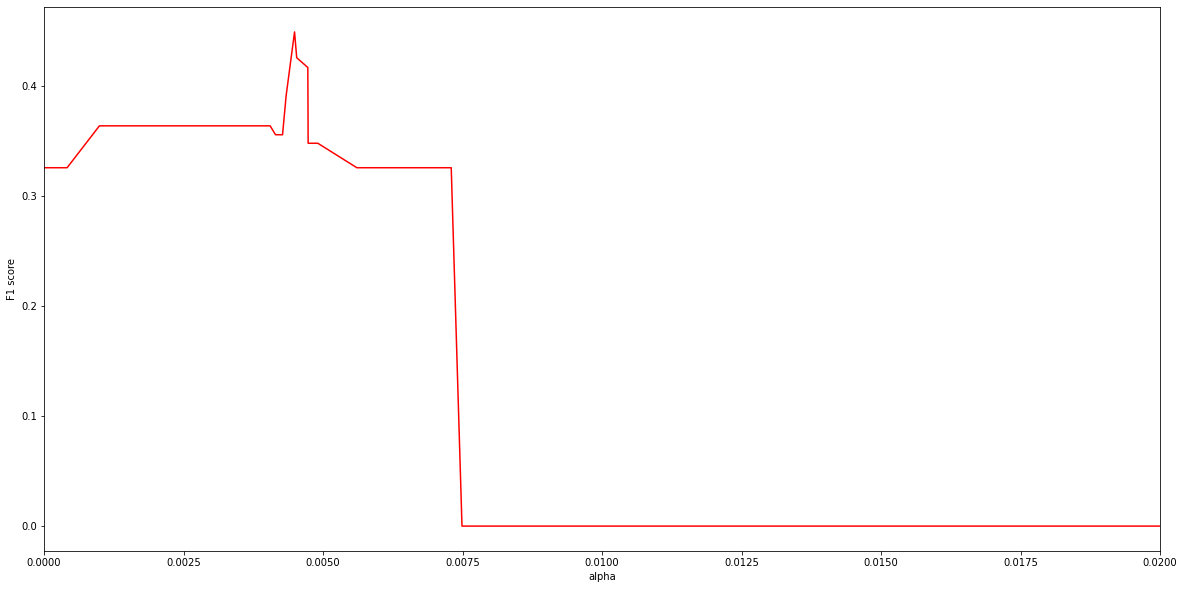

In [26]:
# Let's try cost complexity pruning. I'll first save off the CCP path for the un-tuned tree and acquire the various values of alphas that produce different numbers of nodes in the fitted tree

path = loan_decision_tree.cost_complexity_pruning_path(x_train, y_train)

alphas = path.ccp_alphas

# Now I'll produce a tree for each alpha and save off the F1 score 

ccp_trees_f1_score = []

for i in alphas:
    new_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 666, ccp_alpha = i).fit(x_train,y_train)
    F1_Score = f1_score(y_test, new_tree.predict(x_test))
    ccp_trees_f1_score.append(F1_Score)

# Plot the score at each alpha

plt.figure(figsize = (20,10))
plt.plot(alphas, ccp_trees_f1_score, 'r')
plt.xlabel('alpha')

plt.xlim(0, 0.02)
plt.ylabel('F1 score')



plt.show()


The max F1 score is achieved at alpha = 0.004488808736338927 , which produces an F1 score of: 0.44897959183673464


[Text(0.405, 0.9642857142857143, 'X[4] <= -0.188\nentropy = 0.809\nsamples = 346\nvalue = [260, 86]'),
 Text(0.325, 0.8928571428571429, 'X[5] <= -0.128\nentropy = 0.149\nsamples = 141\nvalue = [138, 3]'),
 Text(0.285, 0.8214285714285714, 'entropy = 0.297\nsamples = 57\nvalue = [54, 3]'),
 Text(0.365, 0.8214285714285714, 'entropy = 0.0\nsamples = 84\nvalue = [84, 0]'),
 Text(0.485, 0.8928571428571429, 'X[1] <= -1.46\nentropy = 0.974\nsamples = 205\nvalue = [122, 83]'),
 Text(0.445, 0.8214285714285714, 'entropy = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.525, 0.8214285714285714, 'X[3] <= 0.979\nentropy = 0.981\nsamples = 198\nvalue = [115, 83]'),
 Text(0.25, 0.75, 'X[6] <= 0.14\nentropy = 0.989\nsamples = 173\nvalue = [97, 76]'),
 Text(0.08, 0.6785714285714286, 'X[2] <= -1.399\nentropy = 1.0\nsamples = 96\nvalue = [49, 47]'),
 Text(0.04, 0.6071428571428571, 'entropy = 0.811\nsamples = 8\nvalue = [6, 2]'),
 Text(0.12, 0.6071428571428571, 'X[2] <= -0.736\nentropy = 1.0\nsamples = 88\nval

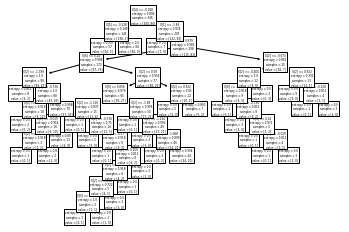

In [27]:
max_score_index = ccp_trees_f1_score.index(max(ccp_trees_f1_score))

print('The max F1 score is achieved at alpha =', alphas[max_score_index], ', which produces an F1 score of:',ccp_trees_f1_score[max_score_index])

# Now as a final step, I'll save off this maximum value of alpha and use it to build a DT on the full training data set, like I did with KNN.

ccp_alpha = alphas[max_score_index]

loan_decision_tree_pruned = DecisionTreeClassifier(criterion = 'entropy', random_state = 666, ccp_alpha = ccp_alpha)
loan_decision_tree_pruned.fit(X, y)

# Plot the final tree 

plot_tree(loan_decision_tree_pruned)

# Support Vector Machine


In [28]:
# First import necessary libraries for model building

from sklearn.svm import SVC

# I'll first initialize and fit a SVM model without hyperparameters tuned, but I'll return to refine it

# I'll pass through default values to the hyperparameters that will be of later interest, to highlight where we will have later flexibility

loan_SVM_init = SVC(C = 1, kernel = 'sigmoid', random_state = 666)

# fit the model to the training data

loan_SVM_init.fit(x_train, y_train)




# form predictions on the test set

yhat_SVM = loan_SVM_init.predict(x_test)

print(classification_report(y_test, yhat_SVM))

print('Initial model build\'s F1 score: ', f1_score(y_test, yhat_SVM))



              precision    recall  f1-score   support

           0       0.77      0.95      0.85        77
           1       0.56      0.19      0.28        27

    accuracy                           0.75       104
   macro avg       0.66      0.57      0.56       104
weighted avg       0.71      0.75      0.70       104

Initial model build's F1 score:  0.2777777777777778


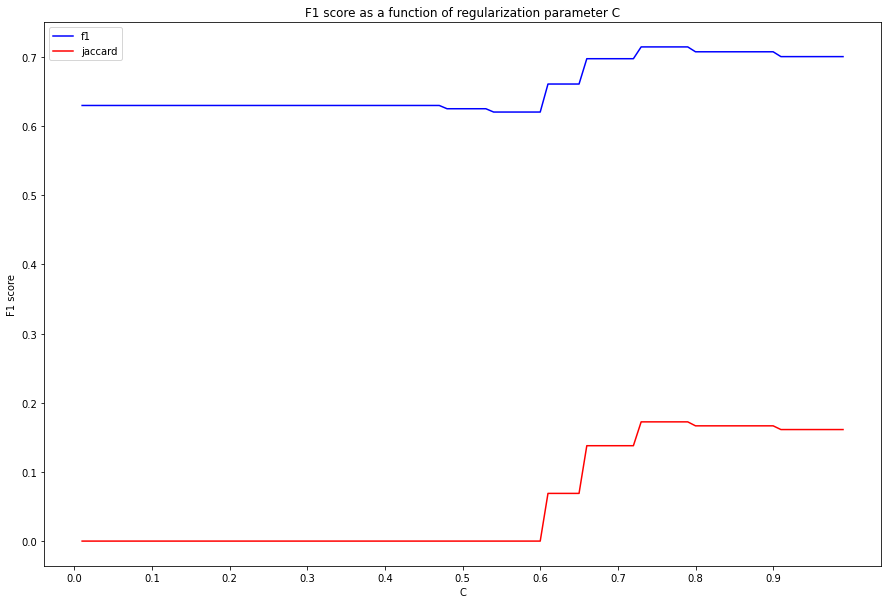

In [29]:
# This method seems pretty trash and I'm not sure why, so I'll play with values of C to see if there's a way to optimize the model

C = np.arange(0.01, 1, 0.01)
SVC_f1_array = [] 
SVC_jaccard_array = []

for c in C:
    SVC_fit = SVC(C = c, kernel = 'sigmoid', random_state = 666).fit(x_train, y_train)
    y_hat = SVC_fit.predict(x_test)
    SVC_f1_array.append(f1_score(y_test, y_hat, average='weighted'))
    SVC_jaccard_array.append(jaccard_score(y_test, y_hat))

plt.figure(figsize=(15,10))

plt.title('F1 score as a function of regularization parameter C')
plt.xlabel('C')
plt.ylabel('F1 score')

xticks = np.arange(0, 1, .1)
plt.xticks(xticks)

plt.plot(C, SVC_f1_array, 'b')
plt.plot(C, SVC_jaccard_array, 'r')
plt.legend(['f1', 'jaccard'])

plt.show()


In [30]:
# I'm not sure what I did differently, but it appears I found an optimal C which performs better than the previous two classifiers.

max_jaccard_index = SVC_jaccard_array.index(max(SVC_jaccard_array))

optimal_C = C[max_jaccard_index]

print('The optimal F1 score is achieved when C = ', optimal_C, ', which produces F1-score:', SVC_f1_array[max_jaccard_index])
print('And Jaccard score: ', SVC_jaccard_array[max_jaccard_index])

The optimal F1 score is achieved when C =  0.73 , which produces F1-score: 0.7146200655328444
And Jaccard score:  0.1724137931034483


In [31]:
# Fit the final model with this C value

loan_SVM_final = SVC(C = optimal_C, kernel = 'sigmoid', random_state = 666).fit(X, y)


# Logistic Regression


In [32]:
# Start by importing the necessary model building libraries from sklearn

from sklearn.linear_model import LogisticRegression

# note that sklearn's Logistic Regression algorithm applies regularization, which can be tuned through the hyperparameter C much like was done for SVM

# We'll start by using the default value for this parameter to get familiar

logistic_regression_init = LogisticRegression(C=1.0, random_state = 666)
logistic_regression_init.fit(x_train, y_train)

# Let's evaluate the trained model's performance on the same test set from earlier

y_hat_lr = logistic_regression_init.predict(x_test)

# print the classification report on both sets

print('Training set: \n',classification_report(y_train, logistic_regression_init.predict(x_train)))

print('Test set: \n',classification_report(y_test, y_hat_lr))


Training set: 
               precision    recall  f1-score   support

           0       0.78      0.93      0.85       183
           1       0.50      0.20      0.29        59

    accuracy                           0.76       242
   macro avg       0.64      0.57      0.57       242
weighted avg       0.72      0.76      0.72       242

Test set: 
               precision    recall  f1-score   support

           0       0.77      0.96      0.86        77
           1       0.62      0.19      0.29        27

    accuracy                           0.76       104
   macro avg       0.70      0.57      0.57       104
weighted avg       0.73      0.76      0.71       104



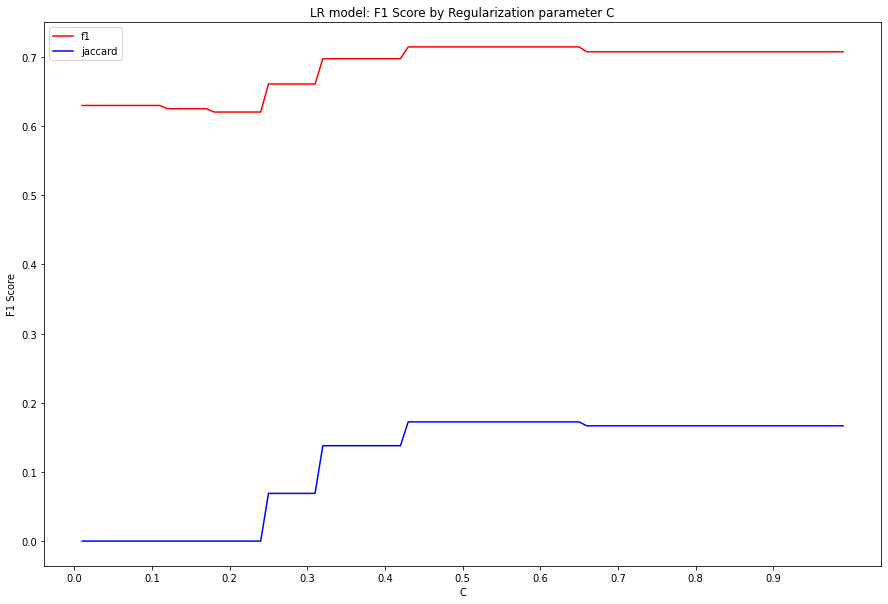

The optimal model is achieved at C =  0.43 , which produces an F1 score of  0.7146200655328444
and a jaccard score of  0.1724137931034483


In [33]:
# Shockingly, the model performs better on the test set :O

# Now, let's further tune this model by finding an optimal value of C. Using F1 score to measure performance

C = np.arange(0.01, 1, 0.01)
f1_array = []
jaccard_array = []

for i in C:
    lr_model = LogisticRegression(C=i, random_state = 666).fit(x_train, y_train)
    yhat = lr_model.predict(x_test)
    f1_array.append(f1_score(y_test, yhat, average = 'weighted'))
    jaccard_array.append(jaccard_score(y_test, yhat))

plt.figure(figsize=(15,10))

plt.title('LR model: F1 Score by Regularization parameter C')
plt.plot(C, f1_array, 'r')
plt.plot(C, jaccard_array, 'b')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.legend(labels=['f1', 'jaccard'])
plt.xticks(np.arange(0, 1, .1))

plt.show()
    
C_max_index = jaccard_array.index(max(jaccard_array))
optimal_C = C[C_max_index]
print('The optimal model is achieved at C = ', optimal_C, ', which produces an F1 score of ', f1_array[C_max_index])
print('and a jaccard score of ', jaccard_array[C_max_index])

In [34]:
# Fit the final model to the entire training set, using the contrived optimal C

logistic_regression_final = LogisticRegression(C = optimal_C, random_state = 666).fit(X, y)



# Model Evaluation using Test set


In [35]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss



First, download and load the test set:


In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-05-04 18:35:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-05-04 18:35:12 (1.70 GB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [38]:
# Perform the same pre-processing steps

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['education'].replace(to_replace=['High School or Below', 'Bechalor'], value=['Bachelor or Below', 'Bachelor or Below'], inplace=True)
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

# Define X_test

X_test = Feature_test

# Define y_test and binarize it

test_df['loan_status_bin'] = test_df['loan_status'] == 'COLLECTION'
test_df['loan_status_bin'] = test_df['loan_status_bin'].astype(int)
y_test = np.asarray(test_df['loan_status_bin'])

# Normalize X_test using the same mean and std from the training feature set, X

X_test = Xscaler.transform(X_test)


X_test[0:5]

print(len(y_test), 'of which this many are defaults', sum(y_test))

54 of which this many are defaults 14


In [39]:
# Now we begin using the final fitted models from earlier to form predictions on the test set

# KNN

yhat_KNN_test = KNN_final.predict(X_test)

# Decision Tree

yhat_DT_test = loan_decision_tree_pruned.predict(X_test)

# Support Vector Machine

yhat_SVM_test = loan_SVM_final.predict(X_test)

# Logistic Regression

yhat_LR_test = logistic_regression_final.predict(X_test)

model_predictions = [yhat_KNN_test, yhat_DT_test, yhat_SVM_test, yhat_LR_test]


In [40]:
print(jaccard_score(y_test, yhat_KNN_test))

y_test_head = y_test[0:10]
yhat_head = yhat_KNN_test[0:10] 

print(y_test_head, '\n', yhat_head)
print(jaccard_score(y_test_head, yhat_head, pos_label = 1, average = 'binary'))



print('Predictions:\nlen:', len(yhat_SVM_test), 'sum:',sum(yhat_SVM_test))
print('Actual:\nlen:', len(y_test), 'sum:', sum(y_test))

0.2222222222222222
[0 0 0 0 0 0 0 0 0 0] 
 [0 0 0 0 1 1 0 0 0 0]
0.0
Predictions:
len: 54 sum: 2
Actual:
len: 54 sum: 14


# Test Scores

In [41]:
Jaccard_scores = []
F1_scores = []
LogLoss = []

for n, yhat in enumerate(model_predictions):
    Jaccard_scores.append(jaccard_score(y_test, yhat))
    F1_scores.append(f1_score(y_test, yhat, average = 'weighted'))
    
    if n == len(model_predictions) - 1:
        LogLoss.append(log_loss(y_test, yhat))
    else:
        LogLoss.append(np.nan)

report_dict = dict(Algorithm = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'], Jaccard = Jaccard_scores, F1_score = F1_scores, LogLoss = LogLoss)
report = pd.DataFrame(report_dict)

report.set_index('Algorithm')

,Jaccard,F1_score,LogLoss
Algorithm,,,
KNN,0.222222,0.714431,NaN
Decision Tree,0.111111,0.657912,NaN
SVM,0.066667,0.660427,NaN
Logistic Regression,0.071429,0.671764,8.314891


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
